In [ ]:
pip install pydub librosa numpy torchaudio speechbrain
pip install webrtcvad

import webrtcvad
from pydub import AudioSegment
from pydub.playback import play

input_file = r'./Audio Files/Her/Her.mp4'
output_file = r'./Audio Files/Her/HerOutput.wav'

def convert_to_wav(input_file, output_file):
    audio = AudioSegment.from_file(
        input_file,
        format = 'mp4',
        )
    audio.export(output_file, format='wav')


convert_to_wav(input_file, output_file)



Create sample files

In [32]:
import librosa
from pydub import AudioSegment
import json

# Load the config file
with open('config.json', 'r') as config_file:
    config = json.load(config_file)

# Access the sampling rate (sr)
sr = config["sr"]

input_file = r'./Data/HerOutput.wav'
sample1= r'./Data/Training_Samples/sample1.wav'

#Pick out sample from 

def t2ms(time_str):
    # Split the time into the part before and after the comma
    time, milliseconds = time_str.split(',')
    
    # Split the time into hours, minutes, and seconds
    hours, minutes, seconds = map(int, time.split(':'))
    
    # Convert everything to milliseconds
    total_ms = (hours * 3600000) + (minutes * 60000) + (seconds * 1000) + int(milliseconds)
    return total_ms


#00:25:11,720 --> 00:25:14,007

#sr = 22050
start_time = t2ms('0:25:11,720')
end_time = (t2ms('00:25:12,807'))

print(f'start time in ms is {start_time} and end time in ms is {end_time}')

#Cut sample segment for pretraining
#audio = librosa.load(input_file)

audio = AudioSegment.from_wav(input_file)
cut_audio = audio[start_time:end_time]
cut_audio.export(sample1, format='wav')  #creating a wav file sample 
    



start time in ms is 1511720 and end time in ms is 1512807


<_io.BufferedRandom name='./Data/Training_Samples/sample1.wav'>

# For Analyzing Speech (e.g., Phoneme Conversion):

    Lower hop_length:
        Provides better time resolution, allowing the model to capture finer details, especially crucial for accurately segmenting phonemes and detecting quick transitions between them.
        More frames = higher granularity in time.
    Higher n_fft:
        Provides better frequency resolution, allowing the model to capture finer frequency details, which are important for distinguishing between different phonemes based on their spectral features.
        More frequency bins = more precise frequency representation.

For Generating Speech (e.g., Speech Synthesis):

    Higher hop_length:
        Reduces the number of frames, which decreases computational cost. It also provides less granular time resolution, but this is often acceptable for generating smoother speech and avoiding overfitting on small time variations.
    Lower n_fft:
        Provides coarser frequency resolution, which can help model more general frequency patterns, reducing computational complexity while still maintaining enough frequency detail for natural speech synthesis.

Summary:

    For analysis: Lower hop_length and higher n_fft (better time and frequency resolution).
    For generation: Higher hop_length and lower n_fft (better computational efficiency, but with slightly reduced resolution in both time and frequency).

Converting WAV --> signal (2D Numpy array)

float32 (23969,) [ 0.00146869  0.00227872  0.00214889 ... -0.00629799 -0.00731505
  0.        ]


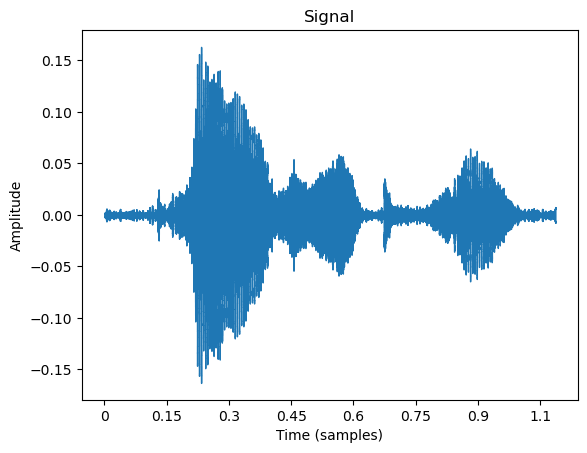

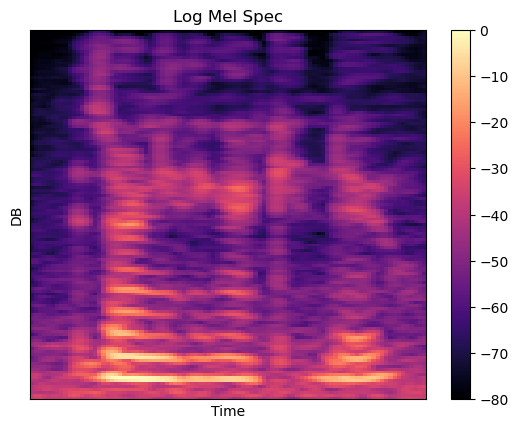

torch.Size([128, 94])
tensor([[-36.5540, -34.2654, -34.2062,  ..., -34.5792, -34.9832, -35.5667],
        [-35.5119, -33.6210, -33.6824,  ..., -36.0578, -36.1539, -36.5224],
        [-39.9536, -40.1816, -41.3776,  ..., -33.2262, -33.3744, -35.2759],
        ...,
        [-80.0000, -80.0000, -80.0000,  ..., -73.2575, -73.5566, -72.6096],
        [-80.0000, -80.0000, -80.0000,  ..., -78.1488, -75.3789, -73.1343],
        [-80.0000, -80.0000, -80.0000,  ..., -80.0000, -76.7486, -73.5600]])


In [59]:
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import torch

sample1= r'./Data/Training_Samples/sample1.wav'

file = sample1

#convert wav file into 1D np.array where the signal's amplitude is normalized between -1 and 1 
signal, _ = librosa.load(file) # sr * T -> 22050 * end_time - start_time
print(signal.dtype, signal.shape, signal)


librosa.display.waveshow(y=signal, sr=sr)
plt.title('Signal')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.show()

n_fft = 2048  # Window length
hop_length = 256 # Hop length
mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=128)
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)



librosa.display.specshow(log_mel_spectrogram, sr=sr, hop_length=hop_length)
plt.title('Log Mel Spec')
plt.xlabel('Time')
plt.ylabel('DB')
plt.colorbar()
plt.show()

aud_tensor = torch.tensor(log_mel_spectrogram, dtype=torch.float32)
print(aud_tensor.shape)
print(aud_tensor)




Converting tensors back into WAV files


In [60]:
import librosa
import librosa.display
import numpy as np
import soundfile as sf

# Reverse Process
mel_spectrogram_reversed = librosa.db_to_power(log_mel_spectrogram, ref=np.max(mel_spectrogram))
linear_spectrogram = librosa.feature.inverse.mel_to_stft(mel_spectrogram_reversed, sr=sr, n_fft=n_fft)

# Use Griffin-Lim to reconstruct the signal
reconstructed_signal = librosa.griffinlim(linear_spectrogram, hop_length=hop_length, n_iter=64)

# Save reconstructed audio
sf.write('reconstructed_audio.wav', reconstructed_signal, sr)


In [9]:
print(sr, signal, signal.dtype, signal.size)
print(np.mean(signal))


22050 [ 0.00213623  0.00210571  0.00222778 ... -0.00708008 -0.00662231
 -0.00674438] float32 23968
-2.4878294e-05


In [10]:
from scipy.io.wavfile import write

output_file = 'output.wav'  # Specify the output file name

# Ensure the signal is scaled to the appropriate range for WAV files
# WAV files typically expect 16-bit PCM, so we scale the signal to int16
scaled_signal = (signal * 32767).astype(np.int16)

# Write the WAV file
write(output_file, sr, scaled_signal)

print(f"WAV file written to {output_file}")


WAV file written to output.wav
